# Use this for spike phase histogram plotting code

definitions

In [1]:
import src.paths
from src.csd import wavelet_transform, resample_1250_250_Hz

In [54]:
def spike_phase_hist(hist, ax=None, ticks=True, tickstride=5):
    if ax is not None:
        plt.sca(ax)
    plt.imshow(hist.values, interpolation='none')
    plt.axis('auto')
    if not ticks:
        return
    freqtick = range(len(hist.columns))[::tickstride]
    freqlabel = np.round(hist.columns, 1)[::tickstride]
    phasetick = np.arange(5) / 4 * (hist.shape[0] - 1)
    phaselabel = ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$-\pi$']
    plt.xticks(freqtick, freqlabel)
    plt.yticks(phasetick, phaselabel)
    return plt.gcf()

In [34]:
ANIMAL = 'M023'
DATE = '2022-09-16'
EPOCH = 0
CHANNEL = 39
FREQ_MIN = 4
FREQ_MAX = 80
FREQ_BINS = 40
PHASE_BINS = 40
LOG_FREQS = True

In [35]:
FRAME_1250 = 1 / 1250
FRAME_250 = 1 / 250
START = (30 * EPOCH + 5) * 60
END = (30 * EPOCH + 25) * 60

load and transform

In [4]:
%%time
csd = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-csd.pkl')
csd = csd.loc[START:END - FRAME_1250, CHANNEL]

CPU times: user 7.09 ms, sys: 6.09 s, total: 6.09 s
Wall time: 7 s


In [36]:
%%time
hilb = wavelet_transform(csd, freq_min=FREQ_MIN, freq_max=FREQ_MAX, freq_bins=FREQ_BINS, log=LOG_FREQS)
hilb = resample_1250_250_Hz(hilb)

CPU times: user 32.7 s, sys: 649 ms, total: 33.4 s
Wall time: 33.4 s


In [37]:
phase = np.angle(hilb.values)
phase = pd.DataFrame(phase, index=hilb.index, columns=hilb.columns)

In [38]:
%%time
spk = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-spikes.pkl')
spk = spk.loc[START:END - FRAME_250]
spk.columns = spk.columns.droplevel('channel')

CPU times: user 10 ms, sys: 552 ms, total: 562 ms
Wall time: 563 ms


spike phase analysis

In [39]:
units = spk.columns
freqs = phase.columns
phase_bins = np.linspace(-np.pi, np.pi, PHASE_BINS + 1)
phases = pd.Series(phase_bins[:-1], name='phase')

In [45]:
%%time
spk_hist = {}
for unit in units:
    spk_train = spk[unit].astype('bool')
    spk_phase = phase[spk_train]
    hist = {}
    for freq in freqs:
        count, _ = np.histogram(spk_phase[freq], phase_bins)
        hist[freq] = count
    spk_hist[unit] = pd.DataFrame(hist, index=phases, columns=freqs)

CPU times: user 982 ms, sys: 10.8 ms, total: 993 ms
Wall time: 992 ms


# Tail

In [44]:
UNIT = 380

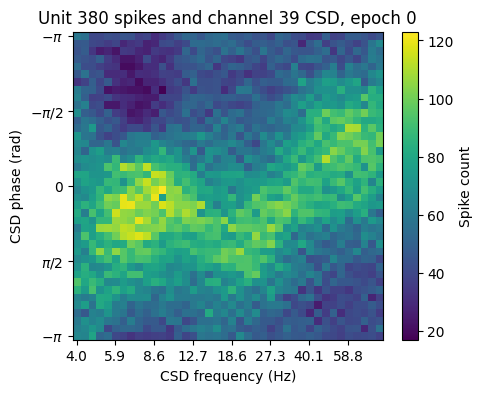

In [60]:
plt.figure(figsize=(5, 4))
spike_phase_hist(spk_hist[UNIT])
plt.title(f'{DATE} channel {CHANNEL} unit {UNIT} time {START}:{END} s')
plt.xlabel('CSD frequency (Hz)')
plt.ylabel('CSD phase (rad)')
plt.colorbar(label='Spike count')
plt.title(f'Unit {UNIT} spikes and channel {CHANNEL} CSD, epoch {EPOCH}')
plt.savefig(f'{DATE}-phase-spike-hist-channel-{CHANNEL}-unit-{UNIT}-epoch-{EPOCH}', dpi=300)
plt.show()